# dPb concentrations across the domain for a single depth level

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import pandas as pd
import xarray as xr
import gsw
import glob
from datetime import datetime

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# model results:
year = 2015
results_folder = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-{year}_20230308/'

# colors:
c_masked = '#eaeae9'
land_color = '#cbcac7'

#### Load files:

In [3]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]

mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_bathy   = mesh['hdept'].values[0]
e3t          = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
land_mask    = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
e3t_masked   = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)

In [4]:
month  = 1
results     = xr.open_dataset(f'{results_folder}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')
lons_model  = results['nav_lon'].values
lats_model  = results['nav_lat'].values
depth_model = results['deptht'].values
dpb_model   = results['dissolpb'].values[0,:,:,:]*1e12

In [5]:
# --- GEOTRACES observations: ---
GTR           = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_cruises   = GTR['metavar1']
GTR_lons      = GTR['longitude'].values              # degrees east
GTR_lats      = GTR['latitude'].values               # degrees north
GTR_pres      = GTR['var1'].values           # Pressure from CTD sensor [dbar]
GTR_depths    = GTR['var2'].values                   # Depth below sea surface calculated from pressure [m]
GTR_temp      = GTR['var3'].values                   # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal       = GTR['var4'].values                   # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_names     = GTR['metavar2'].astype('str').values # Station names

# --- Dissolved Pb concentrations: ---
GTR_qc         = GTR['var16_qc'].values # flag = 51, 52 are probably bad and bad 
GTR_dPb_pmolkg = GTR['var16'].values
GTR_dPb_pmolkg[(GTR_qc == 51) | (GTR_qc == 52)] = np.nan # exclude quality control flagged values

# --- Convert pmol / kg to pmol / L --- (pmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_pressure  = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs   = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density   = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3
GTR_dPb_pmolL = GTR_dPb_pmolkg*GTR_density*1e-3
GTR_dPb_pmolL[GTR_dPb_pmolL < 0] = np.nan # can't have negative concentrations

In [6]:
# Station coordinates and names:
Pb_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
obs_lons  = Pb_data['station lon'].astype('float').dropna().values
obs_lats  = Pb_data['Station lat'].astype('float').dropna().values

# Connect these points with straight line segments:
transect_lons = [obs_lons[stn_names=='CB4'],  obs_lons[stn_names=='CB3'],  obs_lons[stn_names=='CB2'],  obs_lons[stn_names=='CB1'], \
                 obs_lons[stn_names=='CAA8'], obs_lons[stn_names=='CAA6'], obs_lons[stn_names=='CAA7'], -95.128357, obs_lons[stn_names=='CAA4'],\
                 obs_lons[stn_names=='CAA5'], obs_lons[stn_names=='CAA1'], obs_lons[stn_names=='CAA2'], obs_lons[stn_names=='CAA3'],\
                 -76.495545, obs_lons[stn_names=='BB3'], -63.927186, obs_lons[stn_names=='BB1']]
transect_lats = [obs_lats[stn_names=='CB4'],  obs_lats[stn_names=='CB3'],  obs_lats[stn_names=='CB2'],  obs_lats[stn_names=='CB1'], \
                 obs_lats[stn_names=='CAA8'], obs_lats[stn_names=='CAA6'], obs_lats[stn_names=='CAA7'], 74.313002, obs_lats[stn_names=='CAA4'],\
                 obs_lats[stn_names=='CAA5'], obs_lats[stn_names=='CAA1'], obs_lats[stn_names=='CAA2'], obs_lats[stn_names=='CAA3'],\
                 73.658423, obs_lats[stn_names=='BB3'],  70.355341, obs_lats[stn_names=='BB1']]
transect_names = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', '', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3', \
                 '', 'BB3', '', 'BB1']

# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

#### Functions:

In [7]:
def calculate_average(folder_ref_2015):
    # Calculate average over data files during cruise period:
    # 2015 GEOTRACES: 9 August - 15 September
    files_2015      = np.sort(glob.glob(f'{folder_ref_2015}ANHA12_EXH006_5d_20150101_20151231*'))
    start_date_2015 = datetime.strptime(f'2015-08-03', '%Y-%m-%d')
    end_date_2015   = datetime.strptime(f'2015-09-28', '%Y-%m-%d')

    file_list_2015 = []
    for file in files_2015:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            file_list_2015.append(file)

    dpb_2015 = np.zeros((50,isize,jsize))
    days = 0
    for file in file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dpb_2015 = dpb_2015 + ds['dissolpb'].values[0,:,:,:]

    pb_dis_ref_2015 = dpb_2015 / len(file_list_2015)
    
    return pb_dis_ref_2015

In [114]:
def plot_field(ax, proj, variable, layers, obs=False, vmin=0, vmax=35):
    cmap1 = cmocean.cm.matter
    cmap1.set_bad(c_masked, 1)   
    
    if obs:
        GTR_lons_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                         (GTR_lats < 65) & (GTR_lons > 300) | \
                                         (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lons)
        GTR_lats_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                         (GTR_lats < 65) & (GTR_lons > 300) | \
                                         (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lats)
    ax.set_facecolor(c_masked)
    x, y = proj(lons_model, lats_model) 
    plot_variable = np.ma.masked_where(tmask_sub[layers[0],:,:] < 0.1, variable[:,:])
    pcolor  = ax.pcolormesh(x, y, plot_variable, cmap=cmap1, vmin=vmin, vmax=vmax)
    contour = ax.contourf(np.zeros_like(x), np.zeros_like(y), np.zeros_like(plot_variable), np.arange(vmin,vmax+1,1),\
                          cmap=cmap1, vmin=vmin, vmax=vmax, extend='max')

    if obs: #plot circles with 2015 GEOTRACES observations
    # filter based on depth:
        if depth_model[layers[1]] < 200: # in shallow areas use only observations that are within 15 m from layer
            depth_mask     = (GTR_depths > depth_model[layers[0]] - 15) & (GTR_depths < depth_model[layers[1]] + 15)
        else:  # in deeper waters use observations that are within 50 m from the layer
            depth_mask     = (GTR_depths > depth_model[layers[0]] - 50) & (GTR_depths < depth_model[layers[1]] + 50)

        GTR_dPb_masked = np.ma.masked_where(~depth_mask, GTR_dPb_pmolL) # calculate mean over observations within this range
        GTR_dPb_masked = np.ma.masked_where(np.isnan(GTR_dPb_masked), GTR_dPb_masked)
        GTR_dPb_slice  = np.ma.mean(GTR_dPb_masked, axis=1)
            
        x_GTR, y_GTR   = proj(GTR_lons_ma, GTR_lats_ma)
        ax.scatter(x_GTR, y_GTR, c=GTR_dPb_slice, s=80, zorder=3, edgecolor='w', marker='.', 
                   linewidth=0.5, vmin=vmin, vmax=vmax, cmap=cmap1, label='2015 GEOTRACES GN02, GN03')
        
    ax.set_title(f'Depth: {depth_model[layers[0]]:.0f}-{depth_model[layers[1]]:.0f} m', fontsize=8)
    return contour

def plot_mix(variable, layers, vmin=0, vmax1=35, vmax2=35, savefig=False, obs=False):

    fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-fields.pickle','rb'))
    
    for n in range(0,3):
        plot_variable = calculate_depth_weighted(variable, levels=layers[n])
        contour1 = plot_field(ax[0,n], proj1, plot_variable, layers[n], obs=obs, vmin=vmin, vmax=vmax1)
        contour2 = plot_field(ax[1,n], proj2, plot_variable, layers[n], obs=obs, vmin=vmin, vmax=vmax2)
    
    x1, y1 = proj1(transect_vlons, transect_vlats)
    x2, y2 = proj2(transect_vlons, transect_vlats)
    ax[0,0].plot(x1, y1, '--', c='w', linewidth=0.6)
    ax[1,0].plot(x2, y2, '--', c='w', linewidth=0.8)  
    
    cbaxes1 = fig.add_axes([-0.05, 0.41, 0.02, 0.36]);
    CBar1   = plt.colorbar(contour1, ax=ax[0,0], cax=cbaxes1, ticks=np.arange(0,vmax1+2,2)); 
    CBar1.set_label('Dissolved Pb [pM]', fontsize=8)
    CBar1.ax.tick_params(axis='y', length=0, labelsize=7.5)
    
    cbaxes2 = fig.add_axes([-0.05, 0.195, 0.02, 0.17]);
    CBar2   = plt.colorbar(contour2, ax=ax[1,0], cax=cbaxes2, ticks=np.arange(0,vmax2+2,2)); 
    CBar2.set_label('Dissolved Pb [pM]', fontsize=8)
    CBar2.ax.tick_params(axis='y', length=0, labelsize=7.5)
            
    fig.text(0.02, 0.790, 'a)', fontsize=10, weight='bold');
    fig.text(0.35, 0.790, 'b)', fontsize=10, weight='bold');
    fig.text(0.68, 0.790, 'c)', fontsize=10, weight='bold');
    fig.text(0.02, 0.375, 'd)', fontsize=10, weight='bold');
    fig.text(0.35, 0.375, 'e)', fontsize=10, weight='bold');
    fig.text(0.68, 0.375, 'f)', fontsize=10, weight='bold');
    
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R1-fields.jpg', dpi=300, bbox_inches='tight')
    return

In [115]:
def calculate_depth_weighted(dPb, levels=(0,16)):
    
    dPb_weighted     = dPb[levels[0]:levels[1]+1,:,:]*e3t_masked[levels[0]:levels[1]+1,:,:]
    delta_depth      = np.ma.sum(e3t_masked[levels[0]:levels[1]+1,:,:], axis=0) 
                 
    # calculate average:
    dPb_weighted_ave = np.ma.sum(dPb_weighted, axis=0) / delta_depth
    
    return dPb_weighted_ave

#### Calculations

In [116]:
# calculate average over dates of observations:
dissolpb = calculate_average(results_folder)*1e12

#### Figure of concentrations:

Ranges to display: depth-weighted average of
- Polar mixed layer (surface to 40 m)
- subsurface layer (47-110 m)
- Atlantic layer (380-760 m)

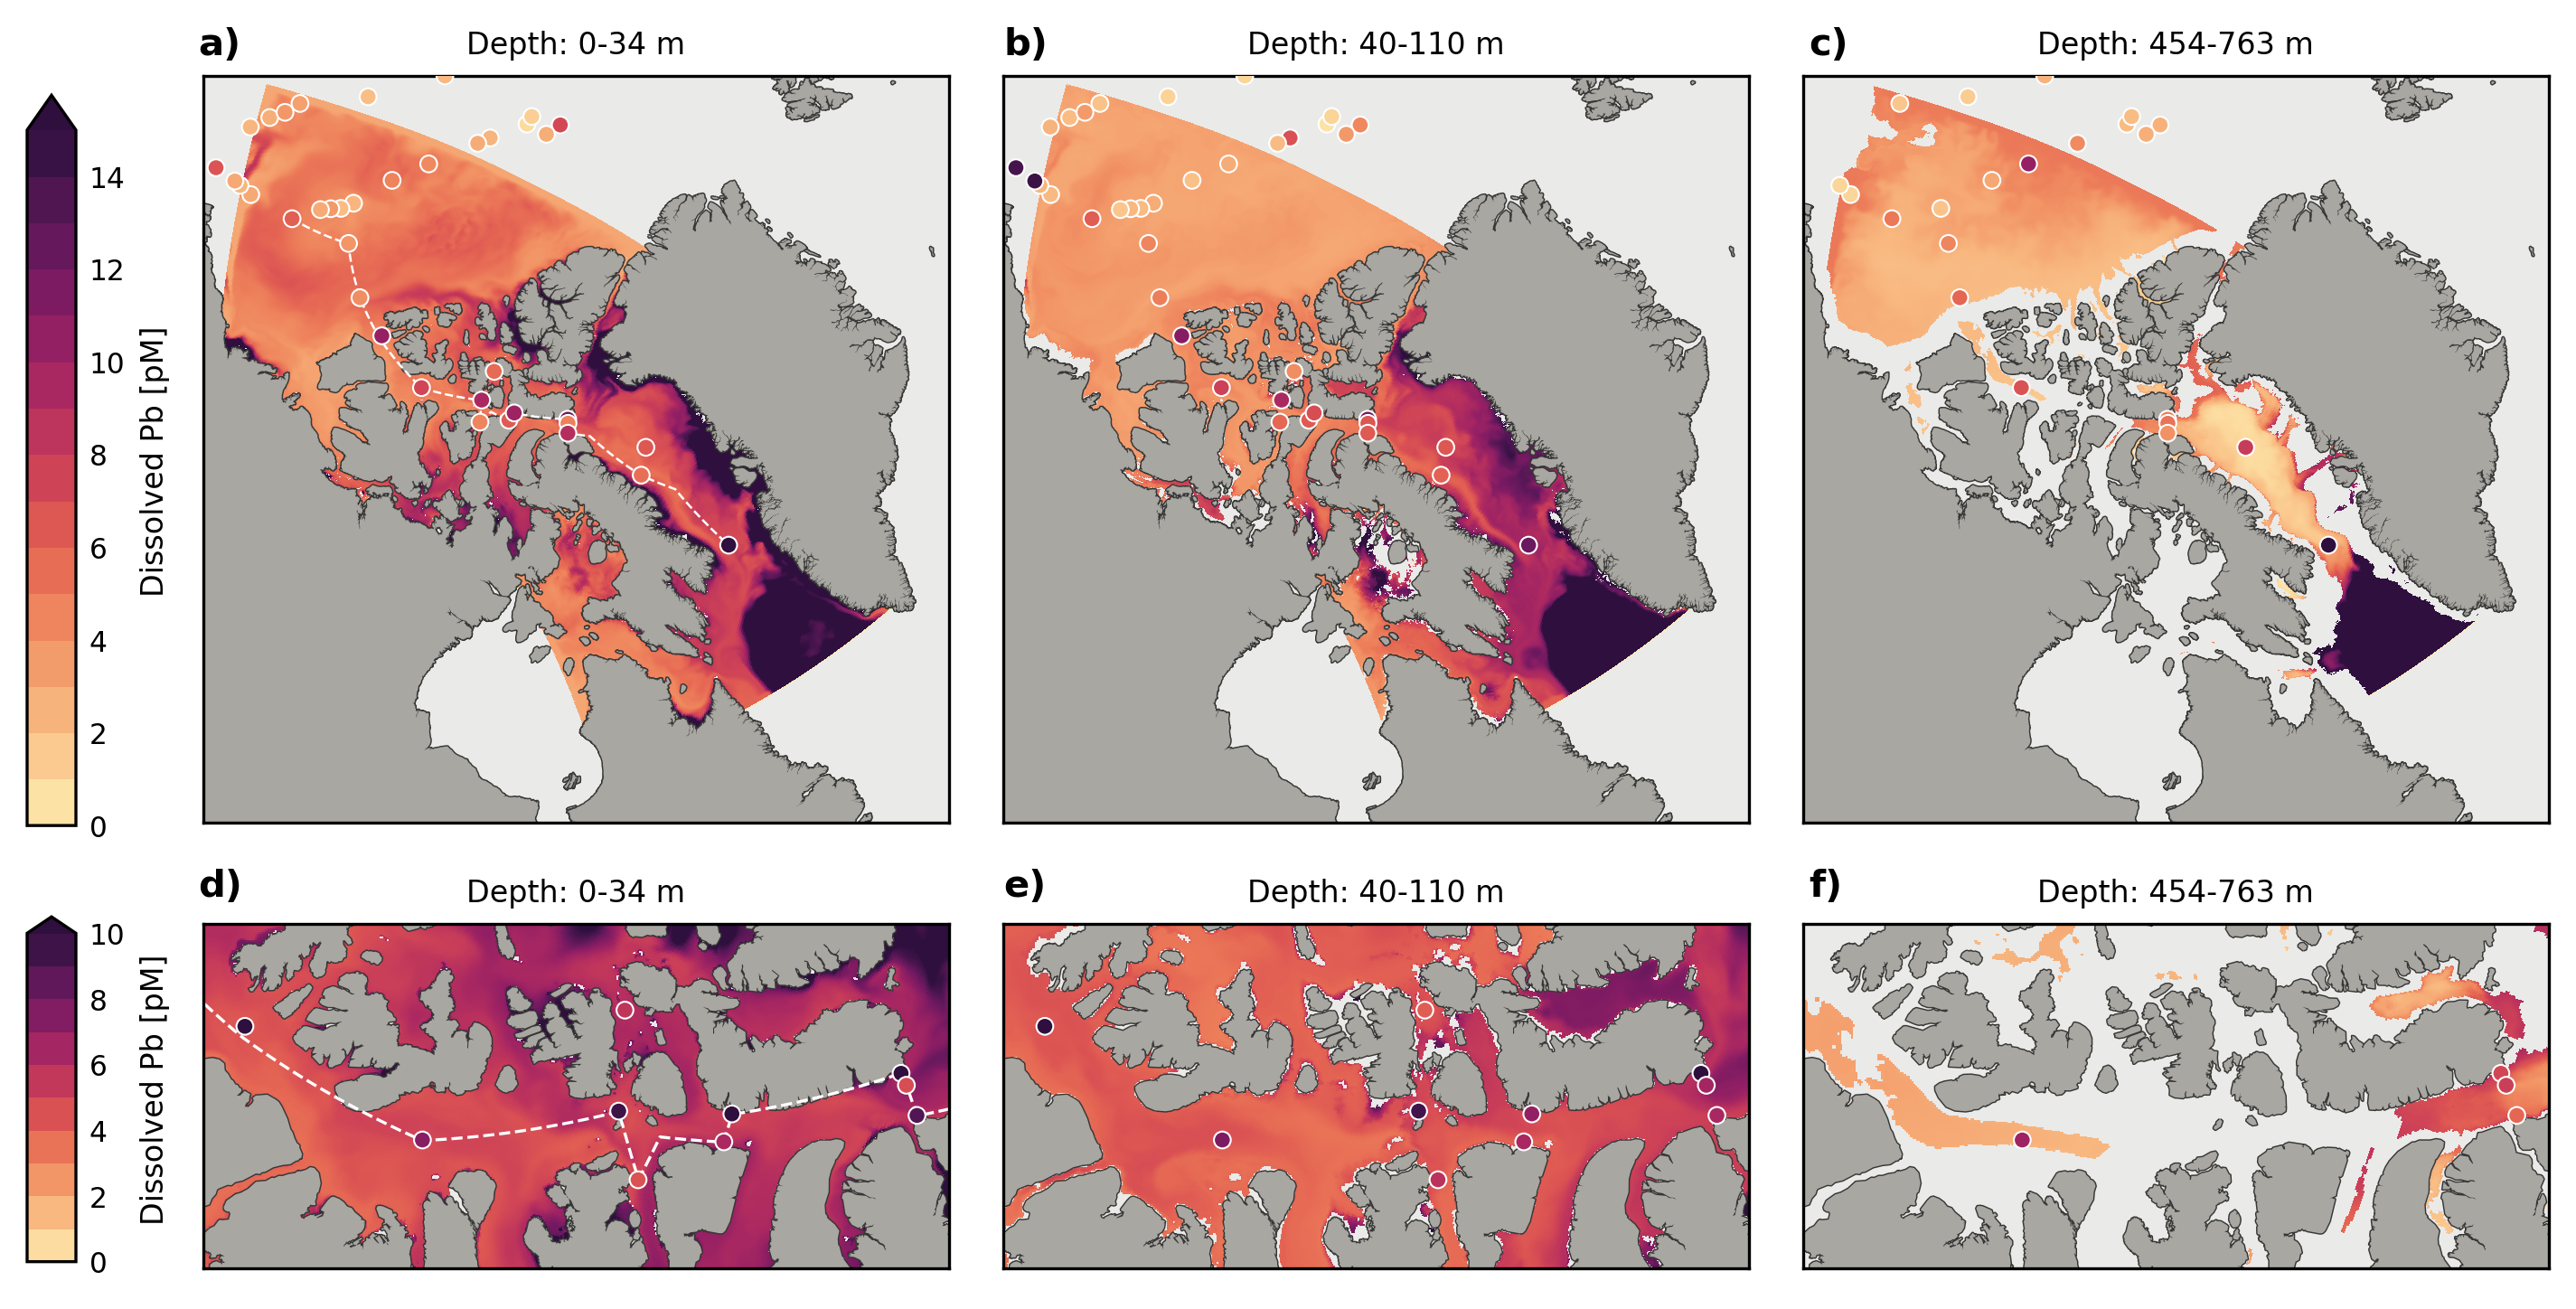

In [121]:
plot_mix(dissolpb, ((0,15),(16,22),(30,33)), vmin=0, vmax1=15, vmax2=10, savefig=True, obs=True)